# Load data, define model

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

In [2]:
#Define parameters 

#### Choose model ####

exp = 'Vienna_5DataSets_1.1_deep' # must be available in the models folder

#### Define data folder ####

path_to_folder = 'Vol5_DICOM_Ice73'

#### Load data and brain mask ####

with h5py.File(path_to_folder+'/CombinedCSI.mat', 'r') as f:
    grp = f['csi']            
    data = grp['Data'][:]   
    # this has shape 840, 35, 64, 64
    # bring to desired shape 64 64 35 840 next:
    data = data.transpose(3,2,1,0)
    data_real = data['real']
    data_imag = data['imag']
    data_complex = data_real+ 1j*data_imag

    #next fourier transform FID domain to spectral domain
    spectra = np.fft.fftshift(np.fft.fft(data_complex, axis=-1), axes=-1)

    # load brain mask:
    brainmask = f['mask'][:]
    brainmask = brainmask.transpose(2,1,0)

#### Load lipid mask ####
img = nib.load(path_to_folder+'/maps/mask_lipid.mnc')
skmask = img.get_fdata()  # get image as a NumPy array
skmask = skmask.transpose(2,1,0)

headmask = brainmask + skmask 

In [3]:
import os
import sys

model_dir = os.path.abspath(f'../models/{exp}')
src_dir   = os.path.abspath(f'../src')

sys.path.insert(0, model_dir)
sys.path.insert(0, src_dir)
#pip install h5py nibabel pandas glob2 regex

import numpy as np
import nibabel as nib
import h5py
import time
from joblib import Parallel, delayed
from tqdm import tqdm
from itertools import product
import scipy
import torch
import torch.nn as nn
os.environ["CUDA_VISIBLE_DEVICES"]= '1' #, this way I would choose GPU 3 to do the work
import scipy.io as sio
from lipidRemoval import *

# compute lipid projection / lipid removal operator

In [4]:
import numpy as np

# ------------------------------------------------------------------
# 1)  Daten vorbereiten  
T        = spectra.shape[-1]                 # 960
Data_rf  = spectra.reshape(-1, T)            # (Nvox, 960)
lipid_rf = Data_rf[skmask.flatten() > 0, :]  # scalp-Voxels

#2)  β bestimmen und Operatoren berechnen
beta, M = find_beta_bisect(lipid_rf)          # garantiert konvergent
RemOP   = np.linalg.inv(np.eye(T) + beta * M)
LipidRem_Operator_ff  = RemOP
LipidProj_Operator_ff = np.eye(T) - RemOP

print(f"Achieved diag-mean = {np.mean(np.abs(np.diag(RemOP))):.4f} at β = {beta:.2e}")


Achieved diag-mean = 0.9377 at β = 4.92e-06


In [5]:
# ——————————— Example usage ———————————
if __name__ == "__main__":
    # 1) Prepare device & experiment name
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # 4) Run lipid removal
    Data_LipidRemoved_rrrf = runNNLipRemoval2(
        device,
        exp,
        spectra,
        LipidProj_Operator_ff,
        headmask,
        batch_size=200
    )


[runNNLipRemoval2] done in 8.5s


In [6]:
Nuisance_Free_FID_Data = np.fft.ifft(np.fft.ifftshift(Data_LipidRemoved_rrrf, axes=-1), axis=-1) # go back to FID domain

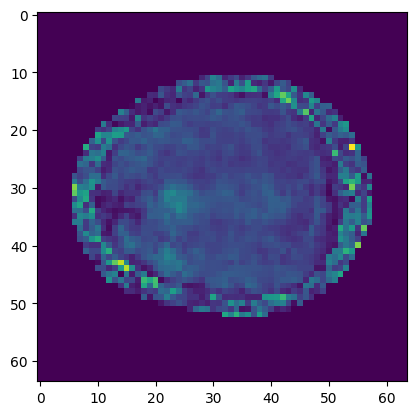

In [7]:
z, t = 20, 4

Slice = np.abs(Nuisance_Free_FID_Data)[:,:,z,t]
plt.imshow(Slice)